In [1]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [2]:
import os
import networkx as nx
import pandas as pd
import random
import numpy as np
from julia import Main
import matplotlib.pyplot as plt

In [3]:
class DataSets:
    base_path = 'data/'
    CORA =     {'path': 'cora/cora.cites', 'sep': '\t', 'name': 'Cora'}  # ~ 5K edges 2K nodes
    FACEBOOK = {'path': 'facebook/facebook_combined.txt', 'sep': ' ', 'name': 'Facebook'} # ~88K edges 4K nodes
    ENRON_EMAILS = {'path': 'enron/email-Enron.txt', 'sep': '\t', 'name': 'Enron Emails'} # ~ 184K edges 33K nodes

    # returns an networkx graph object representing the dataset
    # if lcc is true, it returns only largest connected component
    @classmethod
    def get_undirected_networkx_graph(cls, dataset, lcc=True):
        path = cls.base_path + dataset['path']
        separator = dataset['sep']
        edgelist = pd.read_csv(path, sep=separator, names=['target', 'source'], comment='#')
        G = nx.from_pandas_edgelist(edgelist)
        if lcc == True:
            gs = [G.subgraph(c) for c in nx.connected_components(G)]
            G = max(gs, key=len)
        return G
    
    @classmethod
    def print_graph_properties(cls, dataset):
        path = cls.base_path + dataset['path']
        separator = dataset['sep']
        edgelist = pd.read_csv(path, sep=separator, names=['target', 'source'], comment='#')
        G = nx.from_pandas_edgelist(edgelist)
        print("--", dataset['name'], "--")
        print("FULL GRAPH - nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())
        gs = [G.subgraph(c) for c in nx.connected_components(G)]
        G = max(gs, key=len)
        print("LCC -        nodes:", G.number_of_nodes(), "edges:", G.number_of_edges(), '\n')

In [4]:
DataSets.print_graph_properties(DataSets.CORA)
DataSets.print_graph_properties(DataSets.FACEBOOK)
DataSets.print_graph_properties(DataSets.ENRON_EMAILS)

-- Cora --
FULL GRAPH - nodes: 2708 edges: 5278
LCC -        nodes: 2485 edges: 5069 

-- Facebook --
FULL GRAPH - nodes: 4039 edges: 88234
LCC -        nodes: 4039 edges: 88234 

-- Enron Emails --
FULL GRAPH - nodes: 36692 edges: 183831
LCC -        nodes: 33696 edges: 180811 



In [6]:
class GraphProperties:
    DEGREE_CENTRALITY = {'id': 1, 'name': 'Degree Centrality'}
    BETWEENNESS_CENTRALITY = {'id': 2, 'name': 'Betweenness Centrality'}
    EIGENVALUES = {'id': 3, 'name': 'Eigenvalues'}
    RANK = {'id': 4, 'name': 'Rank'}
    
    @classmethod
    def get_graph_property(cls, G, prop):
        if(prop['id'] == 1):
            return cls._average_degree_centrality(G)
        if(prop['id'] == 2):
            return cls._average_betweenness_centrality(G)
        if(prop['id'] == 3):
            return cls._eigenvalues(G)
        if(prop['id'] == 4):
            return cls._rank(G)
      
    def _average_betweenness_centrality(G):
        return sum(dict(nx.betweenness_centrality(G)).values())/float(len(G))
    

    def _average_degree_centrality(G):
        return sum(dict(nx.degree_centrality(G)).values())/float(len(G))    
    
    # returns sorted list (decreasing) of graph's eigenvalues    
    def _eigenvalues(G):
        L = nx.normalized_laplacian_matrix(G)
        e = np.linalg.eigvals(L.A).real
        e = sorted(e, reverse=True)
        return e
    
    def _rank(G):
        A = nx.to_numpy_matrix(G)
        rank = np.linalg.matrix_rank(A)
        return rank
        

In [7]:
class GraphModifier:
    G = None
    H = None
    
    ADD_RANDOM = 1
    REMOVE_RANDOM = 2
    REMOVE_ORDERED = 3
    
    def __init__(self, graph):
        self.G = graph.copy()
        #self.H = graph.copy()
        
    def perturb_graph(self, perturb_type, percent_edges, offset=None):
        if perturb_type == 1:
            return self._add_random_unweighted_edges(percent_edges)
        if perturb_type == 2:
            return self._remove_random_edges(percent_edges)
        if perturb_type == 3:
            return self._remove_ordered_edges(percent_edges, offset)
        
        
    # returns graph with edges removed, but leaves self.graph unchanged
    def _remove_random_edges(self, percent_edges):
        self.H = self.G.copy()
        num_edges = int(self.G.number_of_edges()*(percent_edges/100))
        current_edges = list(self.G.edges)
        for i in range(0, num_edges):
            current_total_edges = len(current_edges)
            rand_edge_index = random.randrange(current_total_edges)
            edge_tuple = current_edges[rand_edge_index]
            self.H.remove_edge(*edge_tuple)
            del current_edges[rand_edge_index]
        return self.H
    
    def _remove_ordered_edges(self, percent_edges, offset):
        self.H = self.G.copy()
        num_edges = int(self.G.number_of_edges()*(percent_edges/100))
        start_index = num_edges*offset
        end_index = start_index + num_edges
        if end_index > self.G.number_of_edges(): # if out of bounds
            return False
        edge_list = list(self.G.edges)
        edges_to_remove = edge_list[start_index:end_index]
        for edge_tuple in edges_to_remove:
            self.H.remove_edge(*edge_tuple)
        return self.H
    
    # Randomly adds new edges. Percent is the percent of edges originally in graph
    # Currently doesn't avoid duplicates, however randomly generating a duplicate \
    # is rare since the graph is sparse
    # But the number of edges actually added will be slightly less than desired
    # Checking for duplicates is slow
    def _add_random_unweighted_edges(self, percent_edges):
        self.H = self.G.copy()
        num_edges = int(self.G.number_of_edges()*(percent_edges/100))
        node_list =  list(self.H.nodes())
        for i in range(num_edges):
            edge = np.random.choice(node_list, size=2)
            self.H.add_edge(*edge)
        return self.H
            


In [8]:
def sparsify_spanner(G, r):
    return nx.spanner(G, r, seed=7)

In [9]:
def sparsify_spectral(G, ep):
    Main.eval("@eval Main import Base.MainInclude: include")
    Main.include("script.jl")
    
    edgelist = list(G.edges())
    source_nodes = [x[0] for x in edgelist]
    target_nodes = [x[1] for x in edgelist]
    
    Gsparse = Main.sparsifyGraph(source_nodes,target_nodes)
    return Gsparse

In [ ]:
#G = DataSets.get_undirected_networkx_graph(DataSets.CORA)
#sparsify_spectral(G, ep=3)

# Eigenvalues of perturbed graph (no sparsification)

In [ ]:
G = DataSets.get_undirected_networkx_graph(DataSets.CORA)

graph_property = GraphProperties.EIGENVALUES
perturb_type = GraphModifier.REMOVE_RANDOM
percentages = [0,1,3,5,10]
num_trials = 1

df = pd.DataFrame()
modifier = GraphModifier(G)

for percentage in percentages:
    H = modifier.perturb_graph(perturb_type, percentage)
    eigenvalues = GraphProperties.get_graph_property(H, graph_property)
    df[str(percentage)] = eigenvalues[0:1000]

In [ ]:
df = df.loc[0:500]
fig = plt.figure()
#fig.set_size_inches(18.5, 10.5)
plt.plot(df)
plt.legend(df.columns)
plt.show()

# Eigenvalues after sparsifying perturbed graph

In [12]:
G = DataSets.get_undirected_networkx_graph(DataSets.CORA)

graph_property = GraphProperties.EIGENVALUES
perturb_type = GraphModifier.REMOVE_RANDOM
percentages = [0,1,3,5,10]
num_trials = 1

df = pd.DataFrame()
modifier = GraphModifier(G)

for percentage in percentages:
    H = modifier.perturb_graph(perturb_type, percentage)
    Hsparse = sparsify_spanner(H, r=3)
    eigenvalues = GraphProperties.get_graph_property(Hsparse, graph_property)
    df[str(percentage)] = eigenvalues[0:1000]

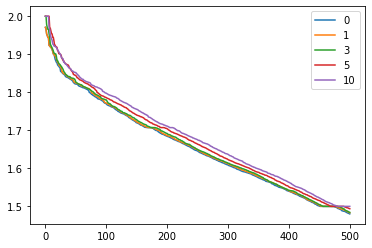

In [13]:
df = df.loc[0:500]
fig = plt.figure()
#fig.set_size_inches(18.5, 10.5)
plt.plot(df)
plt.legend(df.columns)
plt.show()

# Rank

### Without Sparsification

In [15]:
G = DataSets.get_undirected_networkx_graph(DataSets.CORA)

graph_property = GraphProperties.RANK
perturb_type = GraphModifier.REMOVE_RANDOM
percentages = [0,1,2,3,4,5,6,7,8,9,10]
num_trials = 1
original_rank = GraphProperties.get_graph_property(G, graph_property)

modifier = GraphModifier(G)
reduction_rates = []

for percentage in percentages:
    H = modifier.perturb_graph(perturb_type, percentage)
    pert_rank = GraphProperties.get_graph_property(H, graph_property)
    reduction_rate = abs(pert_rank/original_rank - 1)
    reduction_rates.append(reduction_rate)

data = {'pert_rate': percentages,
        'reduction_rate': reduction_rates}
df = pd.DataFrame(data)

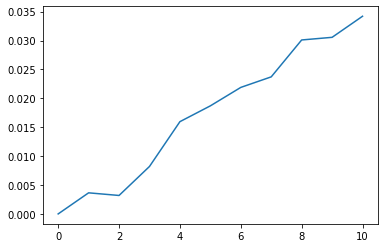

In [16]:
fig = plt.figure()
plt.plot(df['pert_rate'], df['reduction_rate'])
plt.show()

### With Sparsification

In [17]:
G = DataSets.get_undirected_networkx_graph(DataSets.CORA)

graph_property = GraphProperties.RANK
perturb_type = GraphModifier.REMOVE_RANDOM
percentages = [0,1,2,3,4,5,6,7,8,9,10]
num_trials = 1
original_rank = GraphProperties.get_graph_property(G, graph_property)

modifier = GraphModifier(G)
reduction_rates = []

for percentage in percentages:
    H = modifier.perturb_graph(perturb_type, percentage)
    Hsparse = sparsify_spanner(H, r=3)
    pert_rank = GraphProperties.get_graph_property(Hsparse, graph_property)
    reduction_rate = abs(pert_rank/original_rank - 1)
    reduction_rates.append(reduction_rate)

data = {'pert_rate': percentages,
        'reduction_rate': reduction_rates}
df = pd.DataFrame(data)

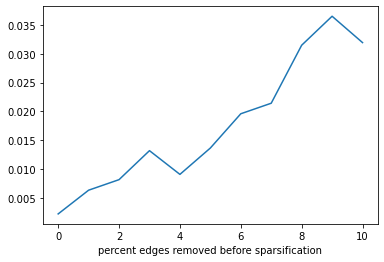

In [19]:
fig = plt.figure()
plt.plot(df['pert_rate'], df['reduction_rate'])
plt.xlabel("percent edges removed before sparsification")
plt.ylabel("rank change rate")
plt.show()

# Run with DEGREE CENTRALITY and ADDING EDGES (randomly)

!!! Currently only small percentages work because speed of Adding Random Edges function (20% takes a 1-2 minutes to do edge removal with ENRON)

In [28]:
G = DataSets.get_undirected_networkx_graph(DataSets.ENRON_EMAILS)

graph_property = GraphProperties.DEGREE_CENTRALITY
perturb_type = GraphModifier.ADD_RANDOM
num_trials = 2
perecent_edges = 5

# Sparsify unperturbed graph and print property
Gsparse = nx.spanner(G,3,seed=1)
prop = GraphProperties.get_graph_property(Gsparse, graph_property)
print(prop, '\n')

# Perturb graph, then sparsify, then print property
modifier = GraphModifier(G)
for i in range(num_trials):
    H = modifier.perturb_graph(perturb_type, perecent_edges)
    sparsify_spanner(H, r=3)
    prop = GraphProperties.get_graph_property(Hsparse, graph_property)
    print(prop)

0.0003126811277128498 

0.00032148341491946186
0.0003214358540320158


# Run with DEGREE CENTRALITY and REMOVING EDGES (randomly)

In [31]:
G = DataSets.get_undirected_networkx_graph(DataSets.ENRON_EMAILS)
num_trials = 5
perecent_edges = 20
graph_property = GraphProperties.DEGREE_CENTRALITY
perturb_type = GraphModifier.REMOVE_RANDOM

# Sparsify unperturbed graph and print property
Gsparse = nx.spanner(G,3,seed=1)
prop = GraphProperties.get_graph_property(Gsparse, graph_property)
print(prop, '\n')

# Perturb graph, then sparsify, then print property
modifier = GraphModifier(G)
for i in range(num_trials):
    H = modifier.perturb_graph(perturb_type, perecent_edges)
    Hsparse = sparsify_spanner(H, r=3)
    prop = GraphProperties.get_graph_property(Hsparse, graph_property)
    print(prop)

0.0003147738067605656 

0.00024533843411508687
0.00024526445051239283
0.0002451746132805436
0.0002457611975590675
0.0002455057779783289


# Run with DEGREE CENTRALITY and REMOVING EDGES (in order)

In [30]:
G = DataSets.get_undirected_networkx_graph(DataSets.ENRON_EMAILS)

graph_property = GraphProperties.DEGREE_CENTRALITY
perturb_type = GraphModifier.REMOVE_ORDERED
percent_edges = 20

# Sparsify unperturbed graph and print property
Gsparse = nx.spanner(G,3,seed=7)
prop = GraphProperties.get_graph_property(Gsparse, graph_property)
print(prop,'\n')
    
# Perturb graph, then sparsify, then print property
total_edges = G.number_of_edges()
num_rounds = int(100/percent_edges)
modifier = GraphModifier(G)
for i in range(num_rounds):
    H = modifier.perturb_graph(perturb_type, percent_edges, offset=i)
    Hsparse = sparsify_spanner(H, r=3)
    prop = GraphProperties.get_graph_property(Hsparse, graph_property)
    print(prop)

0.0003005196326409398 

0.0002512518377878124
0.00025134519804835727
0.0002521114567905541
0.0002537514266503264
0.00025220657856543546


# Run with BETWEENNESS CENTRALITY and REMOVING EDGES (randomly)

! networkx Betweenness Centrality method takes to long on graph 6000+ edges

In [ ]:
graph_property = GraphProperties.BETWEENNESS_CENTRALITY
perturb_type = GraphModifier.REMOVE_RANDOM

# Sparsify unperturbed graph and print property
Gsparse = nx.spanner(G,3,seed=1)
prop = GraphProperties.get_graph_property(Gsparse, graph_property)
print(prop, '\n')

# Perturb graph, then sparsify, then print property
num_trials = 5
percent_edges = .001
modifier = GraphModifier(G)
for i in range(num_trials):
    H = modifier.perturb_graph(perturb_type, percent_edges)
    sparsify_spanner(H, r=3)
    prop = GraphProperties.get_graph_property(Hsparse, graph_property)
    print(prop)